# Histopathlogic Cancer Detection
## Greg Giordano
## Introduction

https://github.com/giordang/CSPB3202_HW5

The goal of this Kaggle competition is to classify pathology images as having metastatic cancer or not. The training data includes ~220k 96x96 images, and the test data includes ~57k 96x96 images. 

### Imports

In [1]:
import os
import cv2
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, Flatten, Dropout, BatchNormalization, Activation
from skimage.io import imread
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tqdm import tqdm_notebook,trange

### Paths

In [2]:
basePath = '/kaggle/input/histopathologic-cancer-detection'
inputPath = '/kaggle/input/histopathologic-cancer-detection/train'
trainPath = '/kaggle/working/train'
valPath = '/kaggle/working/validation'
testPath = '/kaggle/input/histopathologic-cancer-detection/test'
trainLabelPath = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

## Exploratory Data Analysis

Exploratory data analysis is presented below. Example images with labels show that identifying metastatic cancer in the images may be challenging, as no patterns emerge to an untrained eye. However, by taking the distribution of the mean pixel colors, a difference can be seen between the two classes. The positive samples appear to have a normal distribution with a single mode around a value of 150. The negative samples have a bimodal distribution with the most common values being near 120 and 220. A count of the labels show that there is a slight imbalance in the data toward the absence of metastatic cancer. 

### Sample Images

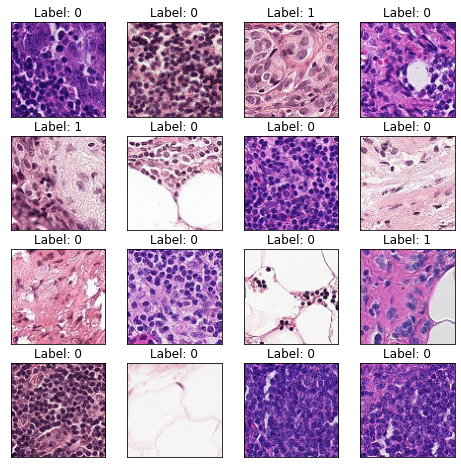

In [3]:
#Adapted random image viewer from below kaggle notebook.
#https://www.kaggle.com/artgor/cancer-detection-with-kekas

trainLabels = pd.read_csv(trainLabelPath)

fig = plt.figure(figsize=(8,8))
inputDir = os.listdir(inputPath)

for count, image in enumerate(np.random.choice(inputDir, 16)):
    ax = fig.add_subplot(4, 4, count + 1, xticks=[], yticks=[])
    img = Image.open(inputPath + '/' + image)
    plt.imshow(img)
    label = trainLabels.loc[trainLabels['id'] == image.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}')

### Label Count

0    130908
1     89117
Name: label, dtype: int64


Text(0.5, 1.0, 'Label Count in Training Data')

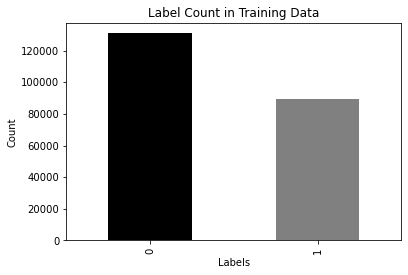

In [4]:
print(trainLabels['label'].value_counts())
trainLabels['label'].value_counts().plot.bar(color=['black','gray']);
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Count in Training Data')

In [5]:
#Create df to hold image id, path to image, and label
df = pd.DataFrame({'path': glob(os.path.join(inputPath, '*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[5].split('.')[0])
dfData = df.merge(trainLabels, on='id')

#Balance data and reduce training data to not fill kaggle workspace
df0 = dfData[dfData['label'] == 0].sample(60000, random_state = 101)
df1 = dfData[dfData['label'] == 1].sample(60000, random_state = 101)
dfData = shuffle(pd.concat([df0, df1], axis = 0).reset_index(drop=True))

#Split training data into train and validation
labels = dfData['label']
dfTrain, dfVal = train_test_split(dfData, test_size=0.10, random_state=101, stratify=labels)

#Set index to id
dfData.set_index('id', inplace=True)
dfData.head()

,path,label
id,,
6dbe880a7f4f8ca50a7576732fda1a65f17e02e2,/kaggle/input/histopathologic-cancer-detection...,1
764017708335373be6cad8e2c688132d4a7d0b0a,/kaggle/input/histopathologic-cancer-detection...,0
d1130ce68aaec3675fa145253ffdf934f26db492,/kaggle/input/histopathologic-cancer-detection...,1
4f0afa3fd85b89a60531b5e8b93bad3ed113c315,/kaggle/input/histopathologic-cancer-detection...,1
1b7d3e8e70b99c5dcc5c3878e787f00e136c67fc,/kaggle/input/histopathologic-cancer-detection...,0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


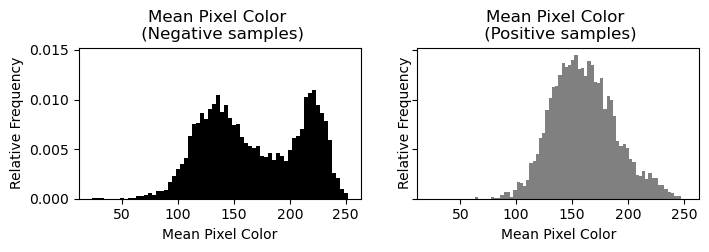

In [6]:
#Histogram of mean pixel values adapted from below kaggle notebook
#https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

dfData_noIndex = dfData.reset_index() #reset index for iteration

xHist = np.zeros([10000, 96, 96, 3], dtype=np.uint8)
yHist = np.squeeze(dfData_noIndex['label'].to_numpy())[0:10000]

for i, row in tqdm_notebook(dfData_noIndex.iterrows(), total = 10000):
    if i == 10000:
        break
    else:
        xHist[i] = cv2.imread(row['path'])

#Split samples into positive and negative values
posSamples = xHist[yHist == 1]
negSamples = xHist[yHist == 0]

bins = 64
fig, axs = plt.subplots(1, 2,sharey = True, sharex = True, figsize=(8,2), dpi = 100)
axs[0].hist(np.mean(negSamples, axis = (1, 2, 3)), bins = bins, density = True, color = 'black')
axs[1].hist(np.mean(posSamples, axis = (1, 2, 3)), bins = bins, density = True, color = 'gray')
axs[0].set_title("Mean Pixel Color \n (Negative samples)")
axs[1].set_title("Mean Pixel Color \n (Positive samples)")
axs[0].set_xlabel("Mean Pixel Color")
axs[1].set_xlabel("Mean Pixel Color")
axs[0].set_ylabel("Relative Frequency")
axs[1].set_ylabel("Relative Frequency");

## Prepare Data
The model was trained with keras model.fit_generator, which requires images to be grouped in directories as train, test, validation, as well as subdirectories in each by label. The sources below were used in organizing and loading the directories.

https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

### Make Directories

In [7]:
#Make training directories
os.makedirs('train')
os.makedirs('train/0')
os.makedirs('train/1')

! ls train

0  1


In [8]:
#Make validation directories
os.makedirs('validation')
os.makedirs('validation/0')
os.makedirs('validation/1')

! ls validation

0  1


### Load Data Into Directories

In [9]:
#Load training directories
for image in dfTrain['id'].values:
    file = image + '.tif'
    label = str(dfData.loc[image, 'label'])
    src = os.path.join(inputPath, file)
    dst = os.path.join(trainPath, label, file)
    shutil.copyfile(src, dst)

In [10]:
#Load validation directories
for image in dfVal['id'].values:
    file = image + '.tif'
    label = str(dfData.loc[image, 'label'])
    src = os.path.join(inputPath, file)
    dst = os.path.join(valPath, label, file)
    shutil.copyfile(src, dst)

### Load Image Data

In [11]:
#Load image data with flow_from_directory

imageSize = (96, 96)

datagen = ImageDataGenerator()

trainIt = datagen.flow_from_directory(trainPath, class_mode = 'binary', target_size = imageSize)
valIt = datagen.flow_from_directory(valPath, class_mode = 'binary', target_size= imageSize)
testIt = datagen.flow_from_directory(valPath, class_mode = 'binary', shuffle=False, target_size=imageSize)

Found 108000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.
Found 12000 images belonging to 2 classes.


## Build Model
A convolutional neural network (CNN) was built to classify the images. CNNs are known to be effective for classifying images and require less computation than artificial neural networks. A keras Sequential model was used to allow the model to be built layer by layer. Convolutional layers with increasing number of nodes, 3x3 filters, and relu activation functions were used in the feature extractor. Dense layers were used in the classifier, with a sigmoid activation function used for the output. Dropout and batch normalization layers are used to prevent overfitting. Maxpool layers were used to reduce the number of parameters between convolution layers.

In [12]:
#Adapted from https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

kernelSize = (3, 3)
inputSize = (96, 96, 3)
opt = Adam(0.01)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size = kernelSize, input_shape = inputSize))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(32, kernel_size = kernelSize, use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(2, 2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(64, kernel_size = kernelSize, use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(64, kernel_size = kernelSize, use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(2, 2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(128, kernel_size = kernelSize, use_bias=False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Conv2D(128, kernel_size = kernelSize, use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.MaxPool2D(2, 2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, use_bias = False))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 94, 94, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0

## Train Model

## Results
The model performs well on the test data, achieving an accuracy above 90%. I started building the model based on the slides from class, using the general [Conv-Conv-MaxPool] structure with 3x3 filters. I was getting poor results, so I looked at some of the successful models available on Kaggle that are mentioned above to see how the layers are commonly structured. I found the best results with 10 or more epochs. I used the Adam optimizer function, and I tried two different learning rates, but did not notice much of a difference.

In [13]:
trainSteps = np.ceil(len(dfTrain) // 32)
valSteps = np.ceil(len(dfVal) // 32)

model.fit_generator(trainIt, steps_per_epoch=trainSteps, validation_data=valIt, validation_steps=valSteps, epochs=11)

Epoch 1/11
3375/3375 [==============================] - 119s 35ms/step - loss: 0.4125 - accuracy: 0.8224 - val_loss: 0.7422 - val_accuracy: 0.6602
Epoch 2/11
3375/3375 [==============================] - 116s 35ms/step - loss: 0.3505 - accuracy: 0.8526 - val_loss: 0.8182 - val_accuracy: 0.6250
Epoch 3/11
3375/3375 [==============================] - 116s 34ms/step - loss: 0.3101 - accuracy: 0.8726 - val_loss: 0.9123 - val_accuracy: 0.6967
Epoch 4/11
3375/3375 [==============================] - 116s 34ms/step - loss: 0.2836 - accuracy: 0.8872 - val_loss: 0.8575 - val_accuracy: 0.6534
Epoch 5/11
3375/3375 [==============================] - 115s 34ms/step - loss: 0.2629 - accuracy: 0.8966 - val_loss: 1.2598 - val_accuracy: 0.6182
Epoch 6/11
3375/3375 [==============================] - 115s 34ms/step - loss: 0.2524 - accuracy: 0.9006 - val_loss: 0.3614 - val_accuracy: 0.8602
Epoch 7/11
2932/3375 [=========================>....] - ETA: 13s - loss: 0.2369 - accuracy: 0.9074

## Test Model


  375/12000 [..............................] - 10s 25ms/step
0.9358835138888889


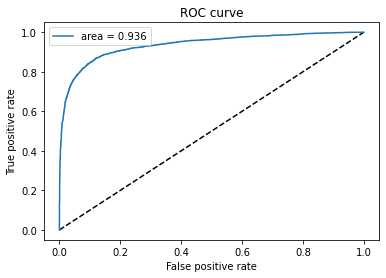

In [14]:
yPred = model.predict_generator(testIt, steps = len(dfVal), verbose = 1)
fpr, tpr, thres = roc_curve(testIt.classes, yPred)
auc = auc(fpr, tpr)
print(auc)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [15]:
sub = pd.DataFrame()
tests = glob(os.path.join(testPath, '*.tif'))

for i in range(0, len(tests), 5000):
    testDf = pd.DataFrame({'path':tests[i:i+5000]})
    testDf['id'] = testDf.path.map(lambda x: x.split('/')[5].split('.')[0])
    testDf['image'] = testDf['path'].map(imread)
    kTest = np.stack(testDf["image"].values)
    preds = model.predict(kTest, verbose=1)
    testDf['label'] = preds
    sub = pd.concat([sub, testDf[['id', 'label']]])

print(len(sub))
sub.head()

77/77 [==============================] - 0s 6ms/step
57458


,id,label
0,eb9e445089aed6402ef64ab0b416a31dfe73fae1,0.010244
1,2e7b0bdc8d15a47f26fb7db84d566f1e773fb708,0.216039
2,a1a9367e1a79f8e807019e2455d6be52d86c2678,0.066401
3,dbc6c9872643f51667bbdfe816c4c5e5b6238706,0.002138
4,a3395030af2286eff7bd94e5dc5a3ddbe5f9c591,0.607147


In [16]:
#Output submission csv
sub.to_csv("submission.csv", index = False, header = True)

In [17]:
#Remove files to prevent Kaggle error
shutil.rmtree(valPath) 
shutil.rmtree(trainPath)

## Conclusion
A CNN is an effective means for classifying these images. Accuracies of 100% have been achieved in this competition, and the model presented here has over 90% accuracy. I learned much from working on the assignment. I found just getting started challenging, as this was my first experience with a large image dataset. I originally was running the models locally without a GPU, which took a long time. I gave Google Colab a brief try, but ultimately settled on just using a Kaggle notebook after I found the GPU toggle and the commit options. It was also my first time working with image data, which required using some libraries that I have not used before. I learned how CNNs are commonly structured, and I experimented with some of the hyperparameters. I'd be interested in learning and understanding more about how to systematically approach designing and optimizing these sorts of models, beyond trial and error and looking at other successful models like VGGNet. I think this assignment was very helpful, and I look forward to doing more on Kaggle in the future.